# Import Libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import Wasserstein

# Load Data

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [11]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Model

In [12]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(512, activation="relu"),
    layers.Dense(10)
])

In [13]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train

In [14]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 7s 12ms/step - loss: 1.4380 - accuracy: 0.4804 - val_loss: 1.1046 - val_accuracy: 0.6118
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 0.9538 - accuracy: 0.6643 - val_loss: 0.8771 - val_accuracy: 0.6987
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.7518 - accuracy: 0.7359 - val_loss: 0.7917 - val_accuracy: 0.7264
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6013 - accuracy: 0.7907 - val_loss: 0.7832 - val_accuracy: 0.7318
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.4657 - accuracy: 0.8371 - val_loss: 0.7339 - val_accuracy: 0.7584
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3247 - accuracy: 0.8874 - val_loss: 0.7820 - val_accuracy: 0.7605
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2054 - accuracy: 0.9293 - val_loss: 0.9380 - val_accuracy: 0.7545

# Attack

In [19]:
art_model = TensorFlowV2Classifier(model=model, loss_object=CategoricalCrossentropy(from_logits=True), nb_classes=10, input_shape=(32, 32, 3), clip_values=(0, 1))

In [27]:
wa = Wasserstein(estimator=art_model, targeted=False, eps=0.7)

In [28]:
adv_test = wa.generate(x=x_test[:4])

Wasserstein:   0%|          | 0/4 [00:00<?, ?it/s]

# Results

In [30]:
safe_preds = np.argmax(art_model.predict(x_test[:4]), axis=1)

In [31]:
safe_preds

array([3, 8, 8, 0])

In [32]:
y_test = np.argmax(y_test[:4], axis=1)

In [33]:
safe_model_scores = {
    'ACC': accuracy_score(y_test, safe_preds),
    'PREC': precision_score(y_test, safe_preds, average='weighted'),
    'REC': recall_score(y_test, safe_preds, average='weighted'),
    'F1': f1_score(y_test, safe_preds, average='weighted')
}

In [34]:
safe_model_scores

{'ACC': 1.0, 'PREC': 1.0, 'REC': 1.0, 'F1': 1.0}

In [35]:
adv_preds = np.argmax(art_model.predict(adv_test), axis=1)

In [36]:
adv_model_scores = {
    'ACC': accuracy_score(y_test, adv_preds),
    'PREC': precision_score(y_test, adv_preds, average='weighted'),
    'REC': recall_score(y_test, adv_preds, average='weighted'),
    'F1': f1_score(y_test, adv_preds, average='weighted')
}

/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
adv_model_scores

{'ACC': 0.0, 'PREC': 0.0, 'REC': 0.0, 'F1': 0.0}

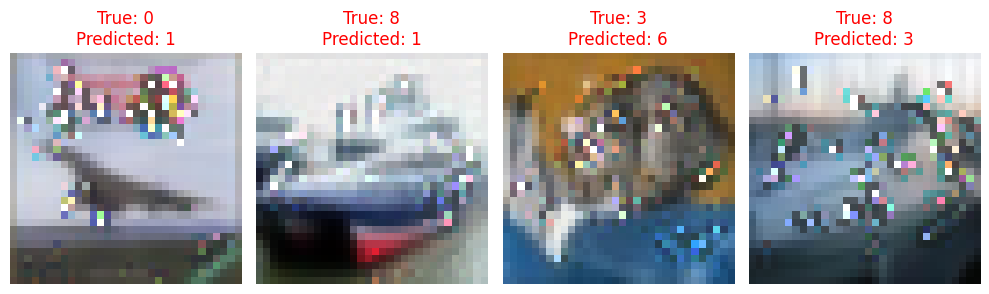

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]], cmap='gray')
    ax.axis('off')

    if y_test[random_index[i]] == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()